# Install Dependencies and Setup

In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Ds Drive/Colab Notebooks/neural3/Tumor'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

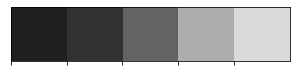

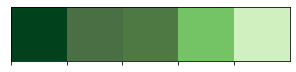

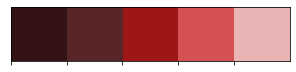

In [ ]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data preparation

In [ ]:
labels = ['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor']

In [ ]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Ds Drive/Colab Notebooks/neural3/Tumor','train',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Ds Drive/Colab Notebooks/neural3/Tumor','test',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 50/50 [00:13<00:00,  3.59it/s]


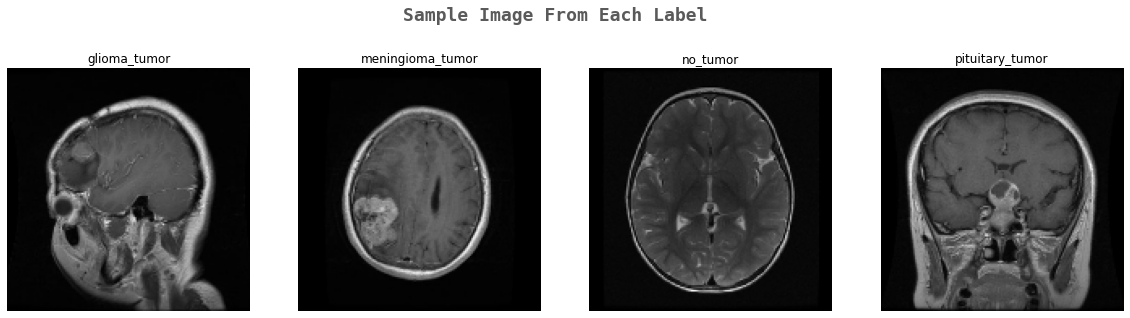

In [ ]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [ ]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [ ]:
X_train.shape

(2095, 150, 150, 3)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

# Build Deep Learning Model

In [ ]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 150, 150, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 150, 150, 3)  0           ['normalization[0][0]']      

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

# Train

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =10, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/10
53/53 [==============================] - ETA: 0s - loss: 0.4772 - accuracy: 0.8196
Epoch 1: val_accuracy improved from -inf to 0.80952, saving model to effnet.h5
53/53 [==============================] - 241s 4s/step - loss: 0.4772 - accuracy: 0.8196 - val_loss: 0.7445 - val_accuracy: 0.8095 - lr: 0.0010
Epoch 2/10
53/53 [==============================] - ETA: 0s - loss: 0.2171 - accuracy: 0.9287
Epoch 2: val_accuracy improved from 0.80952 to 0.88360, saving model to effnet.h5
53/53 [==============================] - 230s 4s/step - loss: 0.2171 - accuracy: 0.9287 - val_loss: 0.4310 - val_accuracy: 0.8836 - lr: 0.0010
Epoch 3/10
53/53 [==============================] - ETA: 0s - loss: 0.1069 - accuracy: 0.9699
Epoch 3: val_accuracy did not improve from 0.88360
53/53 [==============================] - 222s 4s/step - loss: 0.1069 - accuracy: 0.9699 - val_loss: 0.5105 - val_accuracy: 0.8677 - lr: 0.0010
Epoch 4/10
53/53 [==============================] - ETA: 0s - loss: 0.1107 - 

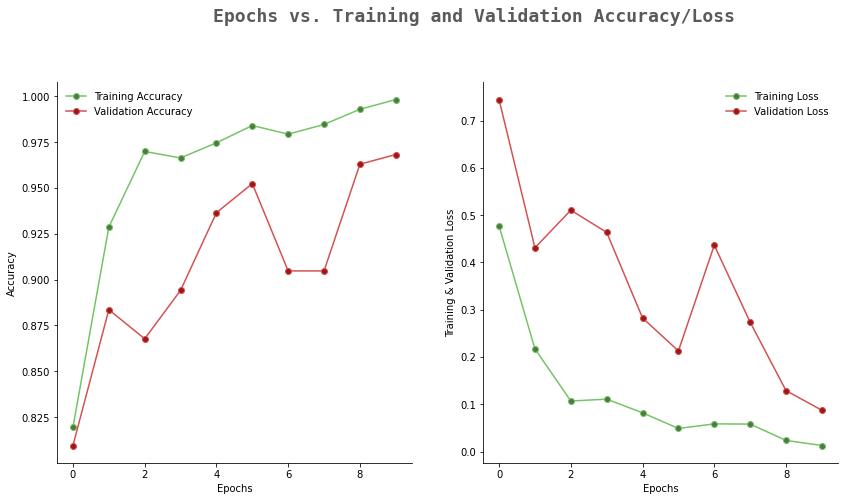

In [ ]:
filterwarnings('ignore')

epochs = [i for i in range(10)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

7/7 [==============================] - 7s 797ms/step


# Evaluation

In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97        58
           1       0.96      0.96      0.96        53
           2       0.98      1.00      0.99        50
           3       1.00      1.00      1.00        49

    accuracy                           0.98       210
   macro avg       0.98      0.98      0.98       210
weighted avg       0.98      0.98      0.98       210



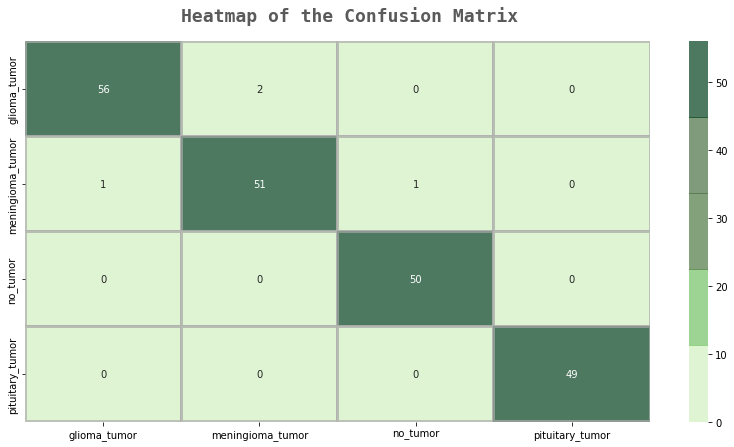

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

In [ ]:
import imghdr
image_exts2 = ['jpeg','jpg', 'bmp', 'png']
folder_dir ='/content/drive/MyDrive/Ds Drive/Colab Notebooks/neural1/Tested/Tested_Tumor'
test_list=[]

for images2 in os.listdir(folder_dir)  :
  image_path2 = os.path.join(folder_dir,images2)
  try:
    img2 = cv2.imread(image_path2)
    #print(img2)
    #list with the images to be tested
    test_list.append(img2)
    tip2 = imghdr.what(image_path2)
    if tip2 not in image_exts2:
        print('Image not in ext list {}'.format(image_path2))
        os.remove(image_path2)
  except Exception as e:
    print('Issue with image {}'.format(os.path.join(folder_dir, image_path2)))
    # os.remove(image_path2)
#print(len(test_list))

In [ ]:
def saveImage(image,id,prediction):

  if prediction==0:
      p='glioma_tumor'
      print('0')
      address='/content/drive/MyDrive/Ds Drive/Colab Notebooks/neural3/Tested_tu/glioma_tumor/' + str(id) +'.jpg'
      cv2.imwrite(address,image)
  elif prediction==1:
      print('meningioma_tumor')
      print('1')
      address='/content/drive/MyDrive/Ds Drive/Colab Notebooks/neural3/Tested_tu/meningioma_tumor/' + str(id) +'.jpg'
      cv2.imwrite(address,image)
  elif prediction==2:
      prediction='no_tumor'
      print('2')
      address='/content/drive/MyDrive/Ds Drive/Colab Notebooks/neural3/Tested_tu/no_tumor/' + str(id) +'.jpg'
      cv2.imwrite(address,image)
  else:
      p='pituitary_tumor'
      print('3')
      address='/content/drive/MyDrive/Ds Drive/Colab Notebooks/neural3/Tested_tu/pituitary_tumor/' + str(id) +'.jpg'
      cv2.imwrite(address,image)


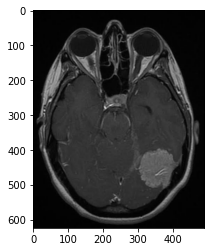

1/1 [==============================] - 0s 87ms/step
meningioma_tumor
1


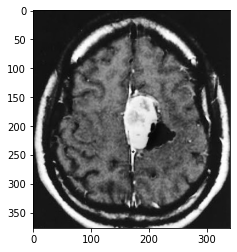

1/1 [==============================] - 0s 54ms/step
meningioma_tumor
1


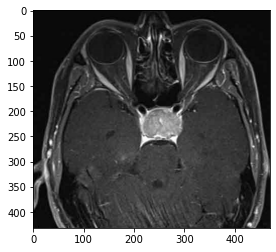

1/1 [==============================] - 0s 54ms/step
3


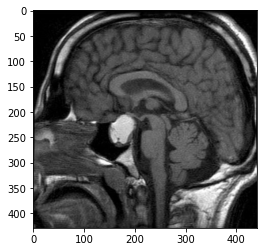

1/1 [==============================] - 0s 63ms/step
3


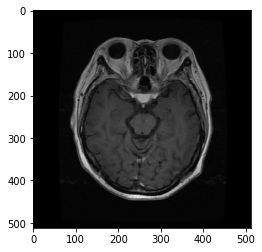

1/1 [==============================] - 0s 84ms/step
3


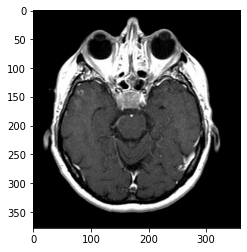

1/1 [==============================] - 0s 58ms/step
3


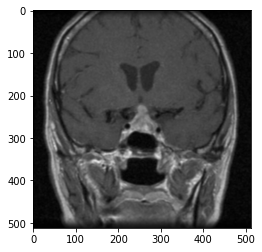

1/1 [==============================] - 0s 69ms/step
3


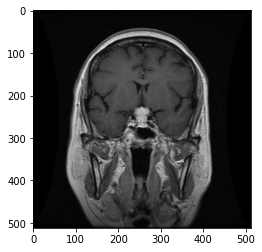

1/1 [==============================] - 0s 63ms/step
meningioma_tumor
1


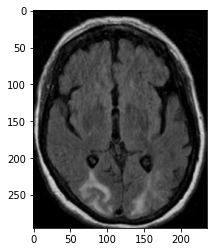

1/1 [==============================] - 0s 59ms/step
2


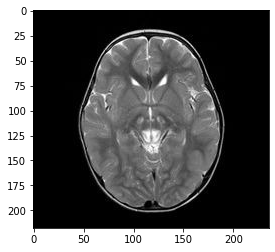

1/1 [==============================] - 0s 64ms/step
2


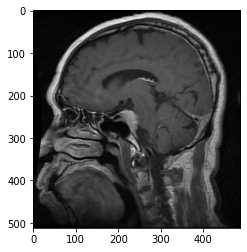

1/1 [==============================] - 0s 56ms/step
3


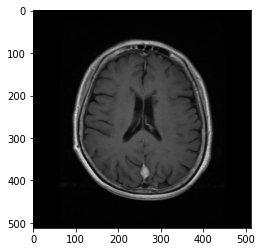

1/1 [==============================] - 0s 55ms/step
meningioma_tumor
1


In [ ]:


i=0

for images2 in test_list:
  plt.imshow(images2)
  plt.show()
  resize = tf.image.resize(images2, (150,150))
  p = model.predict(np.expand_dims(resize, 0))
  p = np.argmax(p,axis=1)[0]

  #print(yhat)
  saveImage(images2,i,p)
  i+=1
  #if yhat > 0.5:
   # print(f'Predicted class for the image is Tumor')
  #else:
   # print(f'Predicted class for the image is Alzheimer')
  yhat=0
  resize=0
